In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio
import zipfile
import IPython
import random
import os
import pickle
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style("darkgrid")
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Control plan:

In [2]:
class Config():
    # Paths
    data_path = # "https://github.com/Jakobovski/free-spoken-digit-dataset"
    load_model_path = r".\model_185.pth"
    
    # Data setup
    sample_rate = 8_000
    max_len = 6_000 # <-- 80% of the sounds has less than 6000 samples
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Model and dataloader config
    batch_size = 6
    workers = 0
    model_bins = 128
    model_channels = 256
    model_dilation_depth = 10
    interpolate_factor = 85 # This seems roughly to be the waveform-length to spectrogram-columns ratio used by Tacotron2 i.e. 1/85 columns per sample
    
    # Training
    already_trained_epochs = 185
    epochs = 100
    learning_rate = 1e-4
    
C = Config()

# Helper functions:

In [3]:
mu = torchaudio.transforms.MuLawEncoding(quantization_channels=C.model_bins)
mu_decoder = torchaudio.transforms.MuLawDecoding(quantization_channels=C.model_bins)

def one_hot(x_mu):
    as_int64 = x_mu.long()
    one_hotted = F.one_hot(as_int64, num_classes=C.model_bins)
    correct_dims = one_hotted.transpose(1,2)
    as_float32 = correct_dims.float()
    return as_float32

def load_sound(path):
    assert os.path.exists(path), "bad path/id given"
    return torchaudio.load(path)[0][0]

def get_tacotron_spectrogram(transcript):
    sequence = np.array(tacotron2.text_to_sequence(transcript, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device=C.device, dtype=torch.int64)
    _, mel, _, _ = tacotron2.infer(sequence)
    return mel.detach()

# Preprocessing:

In [4]:
# Loop over all audio files in the dataset and select select audio files with less than `max_len` samples 
audio_paths = [C.data_path+name for name in next(os.walk(C.data_path))[2]]
data = []

for path in tqdm(audio_paths):
    number_of_samples = torchaudio.load(path)[0].squeeze(0).shape[0]
    if number_of_samples <= C.max_len:
        label = torch.tensor(int(path.split("/")[-1][0]))
        data.append( (path,label) )

  0%|          | 0/3000 [00:00<?, ?it/s]

# Tacotron 2 mel-spectogram generation:

Using cache found in C:\Users\JK/.cache\torch\hub\nvidia_DeepLearningExamples_torchhub


One


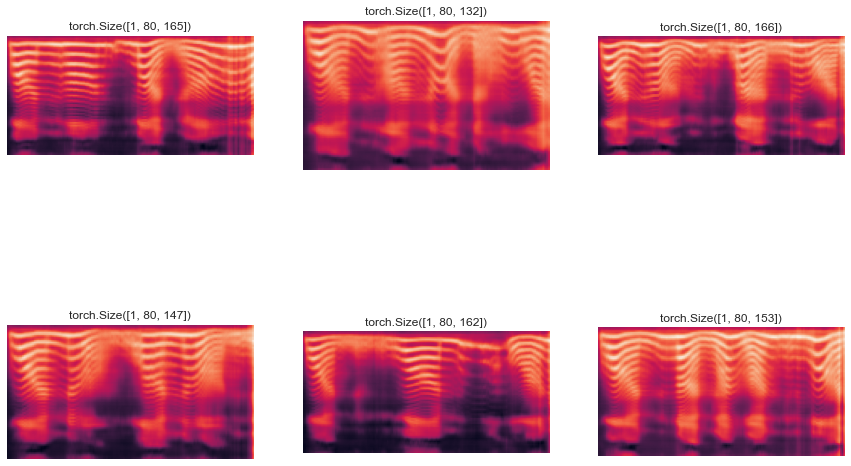

One.


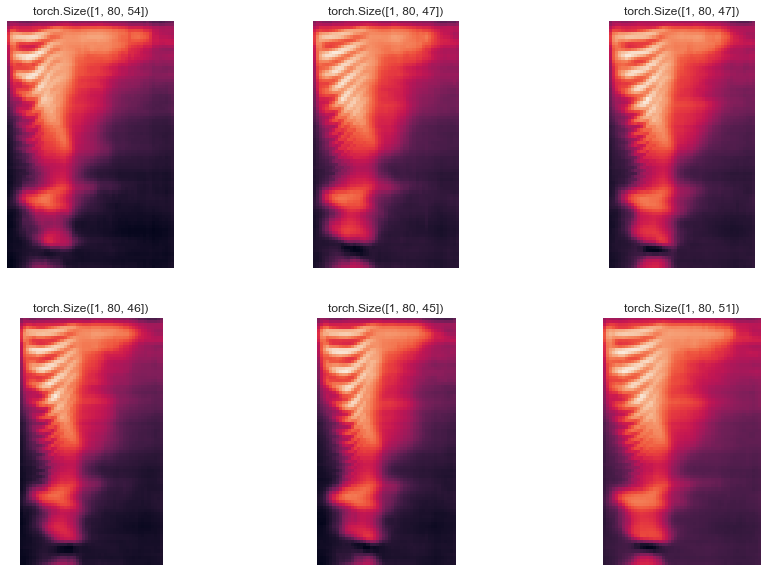

In [5]:
# Load Tacotron 2 model
tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
tacotron2 = tacotron2.to(C.device)
tacotron2.eval();

### Data exploration:

In [ ]:
# Plot transcript for "one" and "one." multiple times (notice stochasticity)
for text in ["One", "One."]:
    print(text)
    _, axes = plt.subplots(2,3, figsize=(15,10))
    for y in range(3):
        for x in range(2):
            mel = get_tacotron_spectrogram(text)

            axes[x][y].imshow(mel[0].cpu().detach().numpy())
            axes[x][y].axis("off");
            axes[x][y].set_title(str(mel.shape))
    plt.show()

### Mel-spectrograms used for traning:

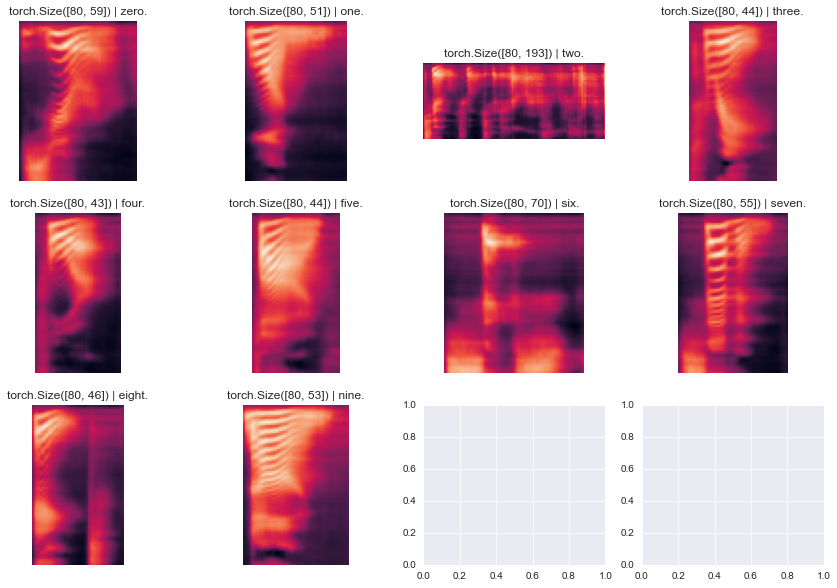

In [6]:
mel_dict = {}
for i, number in enumerate("zero one two three four five six seven eight nine".split()):
    number = number + "."
    mel_dict[i] = get_tacotron_spectrogram(number)

_, axes = plt.subplots(3,4, figsize=(15,10))
for i, number in enumerate("zero one two three four five six seven eight nine".split()):
    number = number + "."
    x,y = i//4, i%4
    mel = mel_dict[i]
    axes[x][y].imshow(mel[0].cpu().detach().numpy())
    axes[x][y].axis("off");
    axes[x][y].set_title(str(mel[0].shape) + " | " + number)
plt.show()

### Example of interpolated and padded spectrogram:

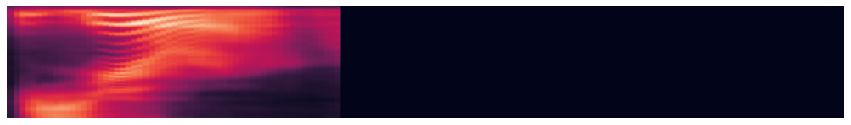

In [7]:
wave_path, label = data[0][0], data[0][1]
waveform = load_sound(wave_path)
pad_amount = C.max_len - len(waveform)
padded_waveform = F.pad(waveform, (0, pad_amount), "constant", 0)

mel = mel_dict[data[0][1].item()]
upscaled_mel = F.interpolate(mel, size=len(waveform), mode='nearest')
mel_padding = torch.ones((1, 80, pad_amount)).to(C.device) * (-10) # -10 ~= black i.e. no sound
padded_mel = torch.cat( (upscaled_mel, mel_padding), dim=2)

audio_paths[0]
IPython.display.Audio(torchaudio.load(audio_paths[0])[0][0], rate=C.sample_rate)

plt.figure(figsize=(15,10)) 
plt.imshow(F.interpolate(padded_mel, size=600, mode='nearest').detach().cpu().numpy()[0])
plt.axis("off");

# Load dataset:

In [8]:
class LJ_Dataset:
    def __init__(self, data, max_len, mel_dict):
        self.data = data
        self.max_len = max_len
        self.mel_dict = mel_dict
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        wave_path, label = self.data[i][0], self.data[i][1]

        waveform = load_sound(wave_path)
        pad_amount = C.max_len - len(waveform)
        padded_waveform = F.pad(waveform, (0, pad_amount), "constant", 0)
        assert len(padded_waveform) == self.max_len, "This should not have happend"
        
        mel = mel_dict[label.item()]
        upscaled_mel = F.interpolate(mel, size=len(waveform), mode='nearest')
        mel_padding = torch.ones((1, 80, pad_amount)).to(C.device) * (-10) # -10 ~= black i.e. no sound
        padded_mel = torch.cat( (upscaled_mel, mel_padding), dim=2)
        assert padded_mel.shape[2] == self.max_len, "This should not have happend"
    
        return padded_waveform, label, padded_mel[0]

# Making the dataset and dataloader
dataset = LJ_Dataset(data, C.max_len, mel_dict)
train_dl = torch.utils.data.DataLoader(dataset,batch_size=C.batch_size, shuffle=True, num_workers=C.workers)

### Sanity check:

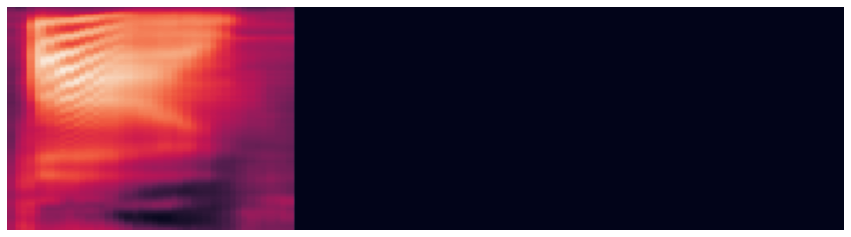

In [9]:
wavs, texts, local_embs = next(iter(train_dl))
display(IPython.display.Audio(wavs[0].numpy(), rate=C.sample_rate))

# The interpolation is just for plotting.
plt.figure(figsize=(15,10)) 
plt.imshow(F.interpolate(local_embs, size=300, mode='nearest').detach().cpu().numpy()[0])
plt.axis("off")

del wavs, texts, local_embs

# WaveNet model:

In [10]:
class WaveNet(nn.Module):
    def __init__(self, quantization_bins=64, channels=128, dilation_depth=10):
        super(WaveNet, self).__init__()
        
        """ Part 1: Define model parameters """""
        self.C = channels
        self.bins = quantization_bins
        self.dilations = [2 ** i for i in range(dilation_depth)]
        self.receptive_field = sum([(2 - 1) * 2 ** i for i in range(dilation_depth)])
        self.causal_layers = nn.ModuleList()

        """ Part 2: Define model layers """
        self.pre_process_conv = nn.Conv1d(in_channels=quantization_bins, out_channels=self.C, kernel_size=1)
        
        for d in self.dilations:
            self.causal_layers.append(ResidualLayer(in_channels=self.C, out_channels=self.C, dilation=d))

        self.local_conv = nn.Sequential(nn.Conv1d(80, self.C, kernel_size=1), nn.ReLU())
        self.post_process_conv1 = nn.Conv1d(self.C, self.C, kernel_size=1)
        self.post_process_conv2 = nn.Conv1d(self.C, self.bins, kernel_size=1)

    def forward(self, x, local_cond):
        """ Function: Makes the forward pass/model prediction
            Input: Mu- and one-hot-encoded waveform. The shape of the input is (batch_size, quantization_bins, samples).
                   It is important that 'x' has at least the length of the models receptive field.
            Output: Distribution for prediction of next sample. Shape (batch_size, quantization_bins, what's left after
                    dilation, should be 1 at inference) """

        """ Part 1: Through pre-processing layer """
        x = self.pre_process_conv(x) 
        
        """ Part 2: Local conditioning """
        local_cond = self.local_conv(local_cond)

        """ Part 2: Through stack of dilated causal convolutions """
        skips, skip = [], None
        
        for layer in self.causal_layers:
            x, skip = layer(x, local_cond=local_cond)
            
            # Save skip connection results
            skips.append(skip)

        """ Part 3: Post processes (-softmax) """
        # Add skip connections together
        x = torch.stack([s[:, :, -skip.size(2):] for s in skips], 0).sum(0) 
        
        # Do the rest of the preprocessing
        x = F.relu(x)
        x = self.post_process_conv1(x)  
        x = F.relu(x)
        x = self.post_process_conv2(x)  
        
        return x

In [ ]:
class ResidualLayer(nn.Module):
    """ Class description: This class is a sub-model of a residual layer """
    
    def __init__(self, in_channels, out_channels, dilation):
        super(ResidualLayer, self).__init__()
        
         """ Part 1: Define model parameters """
        self.dilation = dilation

        """ Part 2: Define model layers """
        self.conv_filter = nn.Conv1d(in_channels, out_channels, kernel_size=2, dilation=dilation)
        self.conv_gate = nn.Conv1d(in_channels, out_channels, kernel_size=2, dilation=dilation)
        
        self.local_conv_filter = nn.Sequential(nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.ReLU())
        self.local_conv_gate = nn.Sequential(nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.ReLU())
        
        # 1 shared 1x1 convolution
        self.conv_1x1 = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x, local_cond):
        # Convolutions
        f_x = self.conv_filter(x)
        g_x = self.conv_gate(x)
        assert f_x.shape == g_x.shape
        
        # Local conditioning
        local_cond = local_cond[:, :, -f_x.shape[2]:]
        local_cond_filter = self.local_conv_filter(local_cond)
        local_cond_gate = self.local_conv_gate(local_cond)
        
        # Send through gate
        f = torch.tanh(f_x + local_cond_filter)
        g = torch.sigmoid(g_x + local_cond_gate)
        z = f * g

        # Save for skip connection
        skip = self.conv_1x1(z)

        # Save residual as input to next layer residual layer
        residual = x[:, :, self.dilation:] + skip

        return residual, skip

# Define WaveNet model, optimizer and loss:

In [11]:
# Construct WaveNet model
model = WaveNet(C.model_bins, C.model_channels, C.model_dilation_depth)
model.to(C.device);

if C.load_model_path:
    model.load_state_dict(torch.load(C.load_model_path))
    print(f"Model has already trained for: {C.already_trained_epochs} epochs")

# Optimizer and loss
optim = torch.optim.Adam(model.parameters(), lr=C.learning_rate)
loss_func = torch.nn.CrossEntropyLoss()
avg_losses = []

Model has already trained for: 185 epochs
torch.Size([6, 128, 4977])


# Training:

In [ ]:
# Training loop
for epoch in range(C.epochs):
    progress_bar = tqdm(train_dl, total=len(train_dl), leave=False)
    losses = []
    for i, (waveforms, _, local_embeddings) in enumerate(progress_bar):
        model.train()
        waveforms.to(C.device)
        local_embeddings.to(C.device)
        
        # Correctly formats data for Wavenet and its loss
        y_true = mu(waveforms).to(C.device)
        x = one_hot(y_true)
        
        # Model predictions
        y_preds = model(x, local_embeddings)   

        # Calculates loss. The whole indexation show is just to align predictions with the true values.
        loss = loss_func(y_preds[:, :, :-1], y_true[:, -y_preds.size(2)+1:])
        
        # Updates
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
        progress_bar.set_postfix({"train_loss": loss.detach().cpu().item()})
    
    # Save model and generate sound every 5 epochs
    if ( (epoch+1) % 5 == 0) or ( (epoch+1) == C.epochs):
        torch.save(model.state_dict(), f"model_{str(epoch + C.already_trained_epochs + 1)}.pth")
        
    avg_losses.append(np.mean(losses))
    print(f"avg_train: {avg_losses[-1]}")

In [ ]:
# Plot average cross entropy loss
plt.figure(figsize=(12,8))
plt.plot(avg_losses, "-o", label="Avg. Cross entropy loss - train")
plt.legend()

# Generate:

In [ ]:
def generate(transcript, model, seed):
    model.eval()
    receptive_field = sum(model.dilations)
    mel = get_tacotron_spectrogram(transcript)
    local_emb =  F.interpolate(mel, size=mel.shape[2]*85, mode='nearest')[0]
    temp = seed.tolist()
    
    for n in tqdm(range(local_emb.shape[1] - receptive_field), leave=False):
        input = torch.tensor(temp[ -(receptive_field+1):])
        input = input.long().to(C.device)
        input = one_hot(input.unsqueeze(0))
        
        single_embedding = local_emb[:, n + receptive_field].view(1,80,1)
        predictions = model(input, single_embedding)
        predictions = torch.softmax(predictions, dim=1)
        sampled_index = torch.multinomial(predictions[0, :, 0], 1).squeeze()
        temp.append(sampled_index.item())

    return temp

def generate_minimal(transcript, model, save_name):
    receptive_field = sum(model.dilations)
    # 60-70 is approx. equal to 0 with mu-encoding and 128 bins
    seed = np.random.randint(60,70, (receptive_field+1)) 
        
    gen = generate(transcript, model, seed)
    mu_decoded_gen = mu_decoder(torch.tensor(gen))
    gen_export = mu_decoded_gen.view(1,-1).float()
    torchaudio.save(f'{save_name}_generated.wav', gen_export, sample_rate=C.sample_rate)

    # Generated sound
    display(IPython.display.Audio(gen_export[0], rate=C.sample_rate))
    plt.figure(figsize=(15,5))
    plt.plot(gen_export[0])
    plt.title(str(transcript))
    plt.show()

In [ ]:
list_of_numbers = "zero. one. two. three. four. five. six. seven. eight. nine.".split(" ")
for i, transript in enumerate(list_of_numbers):
    generate_minimal(transript, model, save_name=f"final_{i}")

### Merge generated integers 0-9 into one audio file:

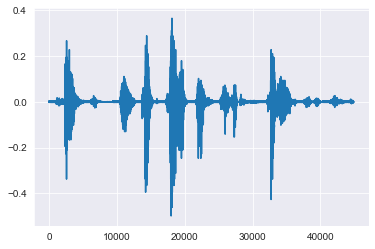

In [13]:
sounds = [load_sound(f"./final_sounds/final_{i}_generated.wav") for i in range(10)]
combined = torch.cat( tuple(sounds[i] for i in range(10)) ).unsqueeze(0)
torchaudio.save(f'combined.wav', combined, sample_rate=8000)
display(IPython.display.Audio('combined.wav', rate=8000))
plt.plot(combined[0])
plt.show()